# DSE Course 2, Lab 1: Practice with Feature Engineering and Pipelines

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this lab we will continue to practice creation of pipelines and feature engineering. For folks doing the course series, you will use your datasets from Project 1 to fulfill the lab requirements. For others, we will use the wine dataset.

<br>

---




In [ ]:
# Pandas library for the pandas dataframes
from copy import copy
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import seaborn as sns
import plotly.express as px
import random
import scipy.stats as stats
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# Code Cell for Exercise 4.2.4
wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

wine['quality_label'] = wine['quality'].apply(lambda x: 'low' if x <=5 else
                                              'med' if x <= 7 else 'high')

wine['type_encoding'] = wine['type'].map({'red': 0, 'white': 1})
wine['quality_encoding'] = wine['quality_label'].map({'low':0, 
                                                      'med': 1, 'high': 2})
y_ql = wine['quality_encoding']
wine.columns = wine.columns.str.replace(' ', '_')

features = list(wine.columns[1:-1].values)
features.remove('quality_label')
features.remove('quality')

# since we use density as a target in some of the examples I'm
# going to make a feature list that doesn't include density
non_density = copy(features)
non_density.remove('density')

# L1 Q1: 

Fill in any missing data in your dataset using imputation and use this new data for Q2-Q3

In [ ]:
# Code Cell for L1 Q1
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(wine[features])
wine_impute = pd.DataFrame(X2, columns=features)
print(wine_impute.shape)
wine_impute.head()

(6497, 12)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_encoding
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1.0


# L1 Q2:

Use 3 different scaling methods on the input data and evaluate how they affect VIF, kurtosis, and skew



In [ ]:
# Code Cell for L1 Q2
wine_impute.skew()

fixed_acidity           1.724131
volatile_acidity        1.496433
citric_acid             0.473142
residual_sugar          1.435221
chlorides               5.400680
free_sulfur_dioxide     1.220066
total_sulfur_dioxide   -0.001177
density                 0.503602
pH                      0.387234
sulphates               1.799021
alcohol                 0.565718
type_encoding          -1.179095
dtype: float64

In [ ]:
wine_impute.kurtosis()

fixed_acidity            5.070143
volatile_acidity         2.834263
citric_acid              2.404077
residual_sugar           4.360399
chlorides               50.911457
free_sulfur_dioxide      7.906238
total_sulfur_dioxide    -0.371664
density                  6.606067
pH                       0.374743
sulphates                8.667071
alcohol                 -0.531687
type_encoding           -0.609922
dtype: float64

In [ ]:
def VIF(wine, features):
  # add intercept for OLS in statmodels
  X = wine[features].assign(constant=1)

  # Calculate VIF Factors
  vif = pd.DataFrame()
  vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in 
                        range(X.shape[1])]
  vif["features"] = X.columns
  return vif.iloc[:-1]#.sort_values("VIF Factor") # here I've omitted the intercept

In [ ]:
VIF(wine_impute, features)

,VIF Factor,features
0,5.008898,fixed_acidity
1,2.164411,volatile_acidity
2,1.620286,citric_acid
3,9.586359,residual_sugar
4,1.658053,chlorides
5,2.236447,free_sulfur_dioxide
6,4.044881,total_sulfur_dioxide
7,22.207092,density
8,2.544397,pH
9,1.553300,sulphates


In [ ]:
def eda(data, features):
  skew = data[features].skew()
  kurt = data[features].kurt()
  vif = VIF(data, features)
  return skew, kurt, vif

In [ ]:
skew, kurt, vif = eda(wine_impute, features)
results = pd.concat([pd.DataFrame([skew,kurt]), vif.set_index('features').T])
results.index = ['skew', 'kurtosis', 'vif']
results

features,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_encoding
skew,1.724131,1.496433,0.473142,1.435221,5.400680,1.220066,-0.001177,0.503602,0.387234,1.799021,0.565718,-1.179095
kurtosis,5.070143,2.834263,2.404077,4.360399,50.911457,7.906238,-0.371664,6.606067,0.374743,8.667071,-0.531687,-0.609922
vif,5.008898,2.164411,1.620286,9.586359,1.658053,2.236447,4.044881,22.207092,2.544397,1.553300,5.586239,7.219469


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_encoding
0,-0.167159,-0.423564,0.284245,3.206977,-0.315222,0.815565,0.959976,2.102214,-1.359665,-0.545959,-1.418558,0.571367
1,-0.707427,-0.241232,0.146523,-0.808136,-0.201027,-0.931107,0.287618,-0.232332,0.508045,-0.277064,-0.831615,0.571367
2,0.681835,-0.362786,0.559689,0.306005,-0.172479,-0.029599,-0.331660,0.134525,0.259017,-0.613183,-0.328521,0.571367
3,-0.012796,-0.666673,0.008801,0.642350,0.055911,0.928254,1.243074,0.301278,-0.176782,-0.882078,-0.496219,0.571367
4,-0.012796,-0.666673,0.008801,0.642350,0.055911,0.928254,1.243074,0.301278,-0.176782,-0.882078,-0.496219,0.571367


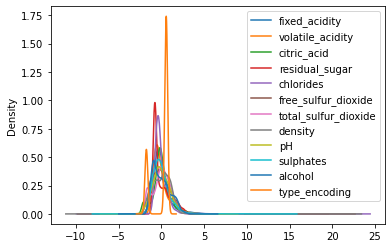

In [ ]:
scaler = StandardScaler()
normed = scaler.fit_transform(wine_impute)
wine_normed = pd.DataFrame(normed, columns=features)
display(wine_normed.head())
wine_normed.plot(kind='kde')

## zero-mean unit variance

In [ ]:
skew, kurt, vif = eda(wine_normed, features)
results = pd.concat([pd.DataFrame([skew,kurt]), vif.set_index('features').T])
results.index = ['skew', 'kurtosis', 'vif']
results

features,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_encoding
skew,1.724131,1.496433,0.473142,1.435221,5.400680,1.220066,-0.001177,0.503602,0.387234,1.799021,0.565718,-1.179095
kurtosis,5.070143,2.834263,2.404077,4.360399,50.911457,7.906238,-0.371664,6.606067,0.374743,8.667071,-0.531687,-0.609922
vif,5.008898,2.164411,1.620286,9.586359,1.658053,2.236447,4.044881,22.207092,2.544397,1.553300,5.586239,7.219469


In [ ]:
pt_scaler = PowerTransformer(method='box-cox', standardize=False)

# box-cox only works with strictly positive data
box_features = [i for i,j in (wine_impute[features] > 0).all().items() if j]
normed = pt_scaler.fit_transform(wine_impute[box_features])
wine_box = pd.DataFrame(normed, columns=box_features)
wine_box.head()

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.704710,-1.581363,2.315374,-6.995612,10.327309,94.987311,0.000988,0.542653,-0.964717,0.540552
1,0.695841,-1.431601,0.450013,-6.638334,5.138100,76.194892,-0.006470,0.560131,-0.844178,0.541934
2,0.715142,-1.529169,1.622166,-6.555646,8.203181,58.196623,-0.005210,0.558030,-0.997321,0.542910
3,0.706882,-1.817921,1.764890,-5.971609,10.579487,102.716352,-0.004649,0.554195,-1.139405,0.542603
4,0.706882,-1.817921,1.764890,-5.971609,10.579487,102.716352,-0.004649,0.554195,-1.139405,0.542603


In [ ]:
skew, kurt, vif = eda(wine_box, box_features)
results = pd.concat([pd.DataFrame([skew,kurt]), vif.set_index('features').T])
results.index = ['skew', 'kurtosis', 'vif']
results

features,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
skew,-0.063260,0.010663,0.069394,-0.058053,-0.040868,-0.179761,-0.020815,-0.000908,-0.007615,0.067033
kurtosis,1.157554,-0.208453,-1.270111,1.078939,-0.087744,-0.457496,0.322114,0.034553,0.167344,-0.973330
vif,2.842670,1.390657,3.712390,2.103212,2.433634,3.054762,9.495345,1.907490,1.413145,3.936149


# L1 Q3:

Create a Pipeline using one of the scaling methods in sklearn and linear or logistic regression 

If you are using the wine dataset:
**_dependent variable:_** wine quality



In [ ]:
# Code Cell for L1 Q3
# create train/test indices so that we can apply these to the different datasets
Xid_train, Xid_test, yid_train, yid_test = train_test_split(
    range(wine.shape[0]), range(wine.shape[0]), random_state=42)

In [ ]:
# and define the function to standardize our model testing
def train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X, y, 
                     verbose=True):
  
  X_train = X.iloc[Xid_train]
  X_test = X.iloc[Xid_test]
  y_train = y.iloc[yid_train]
  y_test = y.iloc[yid_test]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  acc = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred, average='weighted')
  recall = metrics.recall_score(y_test, y_pred, average='weighted')
  f1 = metrics.f1_score(y_test, y_pred, average='weighted')

  if verbose:
    print('Accuracy:  {:2.2%} '.format(acc))
    print('Precision: {:2.2%} '.format(precision))
    print('Recall:    {:2.2%} '.format(recall))
    print('F1 Score:  {:2.2%} '.format(f1))

  return acc, precision, recall, f1

In [ ]:
model = LogisticRegression(penalty='l2',
                           tol=.001,
                           C=.003,
                           class_weight='balanced',
                           solver='sag',
                           max_iter=1e6)

## imputed

In [ ]:
X_imp = pd.merge(wine_impute.loc[:,features],wine['type_encoding'], left_index=True, 
    right_index=True)

In [ ]:
acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X_imp, wine['quality_encoding'])

Accuracy:  40.18% 
Precision: 58.55% 
Recall:    40.18% 
F1 Score:  41.15% 


## box-cox

In [ ]:
X_box = pd.merge(wine_box.loc[:,box_features],wine_impute[['type_encoding', 
                 'citric_acid']], left_index=True, right_index=True)

In [ ]:
acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X_box, wine['quality_encoding'])

Accuracy:  40.00% 
Precision: 62.67% 
Recall:    40.00% 
F1 Score:  43.30% 


## zero-mean unit variance

In [ ]:
X_norm = pd.merge(wine_normed.loc[:,features],wine['type_encoding'], left_index=True, 
    right_index=True)

In [ ]:
acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X_norm, wine['quality_encoding'])

Accuracy:  49.17% 
Precision: 67.53% 
Recall:    49.17% 
F1 Score:  51.54% 


## all together

In [ ]:
data = [X_norm, X_box, X_imp]
data_names = ['Normed', 'Box-Cox', 'Imputed']
performance = []
for data, name in zip(data,data_names):
  acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, 
                                       yid_test, data, wine['quality_encoding'], False)  
  performance.append([acc, pre, rec, f1])
pd.DataFrame(performance, columns = ['Accuracy', 'Precision', 'Recall', 'F1'],
             index=data_names)

,Accuracy,Precision,Recall,F1
Normed,0.492308,0.676641,0.492308,0.515967
Box-Cox,0.400615,0.626899,0.400615,0.433347
Imputed,0.401846,0.585517,0.401846,0.411474


## using pipeline

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def my_pipeline(**kwargs):
    return make_pipeline(StandardScaler(),
                         LogisticRegression(**kwargs))

In [ ]:
pipe = my_pipeline()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, 
                                                    wine['quality_encoding'], 
                                                    train_size=0.8)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
y_pred = pipe.predict(X_test)

cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[273, 196,   0],
       [115, 673,   0],
       [  5,  38,   0]])